# The aim of this repo is to find lines, their shape, curvature and position in the real-world.
 - We assume we get the image after undistortion, thresholding gradient, and perspective transform.
 - **Author:** Marcelo Garcia

The pipeline consists of:

* Histogram peaks

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Histogram peaks technique

In [2]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    height, width = np.shape(img)
    bottom_half = img[np.int(height/2):,:]

    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0) ## *Note 
    return histogram, bottom_half

**\*Note:** Remember that in python matrices Axis 0 is vertical and Axis 1 Horizontal. Please follow this [link](https://www.google.com/search?q=axis+matrix+vertical+python+0+or+1&rlz=1C1GCEV_enUS844US844&sxsrf=ALeKk01cg2AjnFSQHKlmTDxztSHOVL2I7Q:1585166509942&tbm=isch&source=iu&ictx=1&fir=gPcqaRZ_oIIdYM%253A%252Cb-NRbyCLWv1F-M%252C_&vet=1&usg=AI4_-kRnVAMrJh_g1KcceBtAuillQfGCOQ&sa=X&ved=2ahUKEwjDnvC1tbboAhUKQq0KHdYvA5kQ9QEwAHoECAcQAw#imgrc=gPcqaRZ_oIIdYM:) for illustration purposes

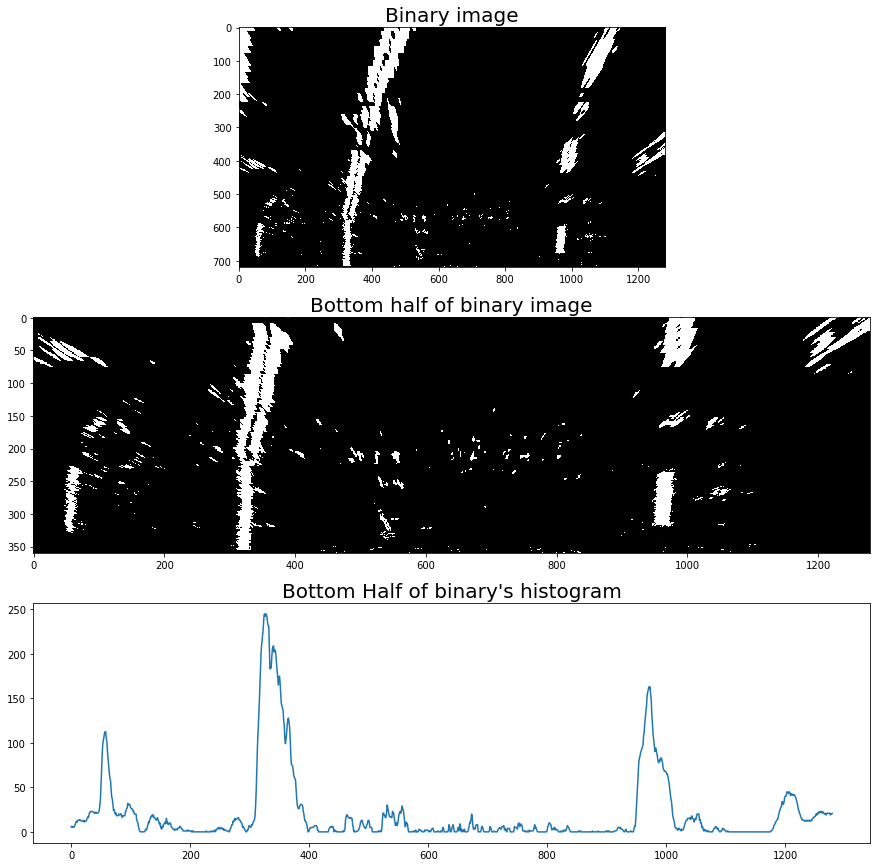

In [3]:
# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = mpimg.imread('warped-example.jpg')/255 # remember image is a binary picture after perspective calibration, undistortion, gradient & HSL thersholds, perspective transform

# Create histogram of image binary activations
histogram, bottom_half = hist(img)
# Visualize the resulting histogram
fig, [ax1, ax2, ax3] =plt.subplots(3,1, figsize=(15,15))

ax1.imshow(img, cmap='gray')
ax1.title.set_text('Binary image')
ax1.title.set_fontsize(20)
ax3.plot(histogram)
ax3.title.set_text('Bottom Half of binary\'s histogram')
ax3.title.set_fontsize(20)
ax2.imshow(bottom_half, cmap='gray')
ax2.title.set_text('Bottom half of binary image')
ax2.title.set_fontsize(20)
plt.show()

**Conclusion:** From the illustrations above you can tell that in fact the histogram peaks are most likely at the lane lines. Therefore, this is a good and easy way way to find the x position of the starting points of the lane lines

# Sliding windows

As shown in the previous images, we can use the two highest peaks from our histogram as a starting point for determining where the lane lines are. However, we then need to know where the lines go, hence, we will take small windows from the starting point up to the top of the image. 

### Split the histogram for the two lines

1st step is to split the lines for the two lines, one for the left line and the other for the right line

In [4]:
# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = mpimg.imread('warped-example.jpg')/255 # remember image is a binary picture after perspective calibration, undistortion, gradient & HSL thersholds, perspective transform

def starting_pos_lines(img):
    # Take a histogram of the bottom half of the image
    histogram, _ = hist(img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    hist_Lenght = histogram.shape[0]
    midpoint = np.int(hist_Lenght//2)#two slashes to apply floor to the division. i.e. floor(3/2) = 3//2
    # Find position of left peak and right peak
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base

### Create the sliding windows algorithm

first we will create a window limits through `window_boundaries()` function. To understand the function please refer to the drawing below:

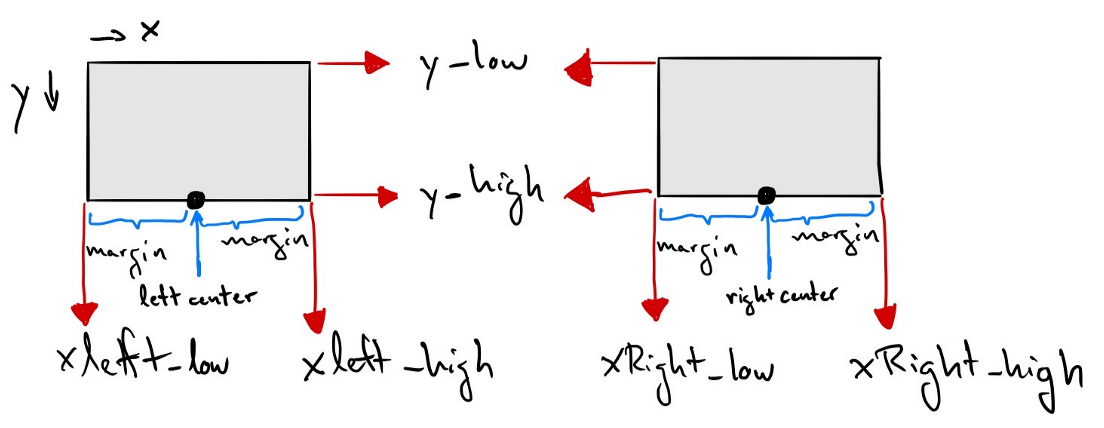

In [5]:
def window_boundaries(binary_warped_img, curr_window, window_height, margin, left_center, right_center):
    """
        This function creates the windows for the left and right lines
        
        Output: dictionary with the boundaries of the windows
    """
    warped_img_height = binary_warped_img.shape[0]

    win_y_low = warped_img_height - (curr_window+1)*window_height
    win_y_high = win_y_low + window_height
    win_xLeft_low = left_center-margin
    win_xLeft_high = left_center+margin
    win_xRight_low = right_center-margin
    win_xRight_high = right_center+margin
    dictWindow = {'y_high': win_y_high, 'y_low': win_y_low, 'xLeft_low': win_xLeft_low,
                 'xLeft_high': win_xLeft_high, 'xRight_low': win_xRight_low, 'xRight_high': win_xRight_high}
    return dictWindow

def draw_windows(out_img, xLeft_low, xLeft_high, xRight_low, xRight_high, y_low, y_high):
    """
        This function draws rectangles on the out_img based on the opposite corners coordinates of
        the rectangle
    """
    cv2.rectangle(out_img, (xLeft_low,y_low), (xLeft_high, y_high), color = (0,255,0), thickness = 2)
    cv2.rectangle(out_img, (xRight_low,y_low), (xRight_high, y_high), color = (0,255,0), thickness = 2)
    
    return out_img

def active_pixels_window(img_act_pixels_x, img_act_pixels_y, xLeft_low, 
                         xLeft_high, xRight_low, xRight_high, y_low, y_high):
    """
        This function outputs a list of active pixels in the current window
    """
    # nonzero function returns the indexes of all true values as false is equivalent to zero
    win_act_pixels_left__ind = np.nonzero((img_act_pixels_x >= xLeft_low) & (img_act_pixels_x < xLeft_high) & (
                            img_act_pixels_y >= y_low) & (img_act_pixels_y < y_high))[0] 

    win_act_pixels_right__ind = np.nonzero((img_act_pixels_x >= xRight_low) & (img_act_pixels_x < xRight_high) & (
                            img_act_pixels_y >= y_low) & (img_act_pixels_y < y_high))[0] 
    
    return win_act_pixels_left__ind, win_act_pixels_right__ind

def update_window_centers(left_center, right_center, win_act_pixels_left__ind, win_act_pixels_right__ind, 
                          img_act_pixels_x, minpix):
    """
        Update current window center based on minpix parameter
        
        If found > minpix pixels, recenter next window on their mean position
    """

    if len(win_act_pixels_left__ind) > minpix:
        new_left_center = np.int(np.mean(img_act_pixels_x[win_act_pixels_left__ind]))
    else:
        new_left_center = left_center
        
    if len(win_act_pixels_right__ind) > minpix:
        new_right_center = np.int(np.mean(img_act_pixels_x[win_act_pixels_right__ind]))
    else:
        new_right_center = right_center
        
    return new_left_center, new_right_center

In [6]:
def sliding_windows(binary_warped_img, nwindows, margin, minpix, visualize=False):
    """
        This function creates a list with the position (x,y) of the pixels that are part of the lines
    """
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped_img.shape[0]//nwindows)
    
    # Get the indices of all nonzero elements in the image. AKA activated pixels
    nonzeroY, nonzeroX = binary_warped_img.nonzero();
    nonzeroX = np.array(nonzeroX) # activated pixels indexes in the X direction
    nonzeroY = np.array(nonzeroY) # activated pixels indexes in the Y direction
    
    # setting starting position lines as current position for each window, they could be updated later
    leftx_base, rightx_base = starting_pos_lines(binary_warped_img)
    leftx_current_center = leftx_base
    rightx_current_center = rightx_base
    
    # Create an output image to draw on and visualize the result
    out_img = (np.dstack((img, img, img))*255).astype(np.uint8)
    
    # List of all active pixels index in all windows for left and right lines
    left_act_pixels__ind = []
    right_act_pixels__ind = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        # get curret window boundaries
        windowData = window_boundaries(binary_warped_img, window, window_height, margin, 
                          left_center=leftx_current_center, right_center=rightx_current_center)
        
        # Visualize windows in case visualize is set to True
        if visualize:
            out_img = draw_windows(out_img, windowData['xLeft_low'], windowData['xLeft_high'], 
                                   windowData['xRight_low'], windowData['xRight_high'], 
                                   windowData['y_low'], windowData['y_high'])

        # Identify all active pixels in the window
        win_act_pixels_left__ind, win_act_pixels_right__ind = active_pixels_window(
                             nonzeroX,  nonzeroY,
                            windowData['xLeft_low'], windowData['xLeft_high'], 
                            windowData['xRight_low'], windowData['xRight_high'], 
                            windowData['y_low'], windowData['y_high'])
        
        # Populate lists of all active pixels in all windows from left and right lines
        left_act_pixels__ind = np.concatenate((left_act_pixels__ind, win_act_pixels_left__ind))
        right_act_pixels__ind = np.concatenate((right_act_pixels__ind, win_act_pixels_right__ind))
        # parse to int indexes must always be integers
        left_act_pixels__ind = left_act_pixels__ind.astype(np.int)
        right_act_pixels__ind = right_act_pixels__ind.astype(np.int)
        
        # Update current window center based on minpix parameter
        leftx_current_center, rightx_current_center= update_window_centers(leftx_current_center, rightx_current_center, 
                                                                    win_act_pixels_left__ind, win_act_pixels_right__ind,
                                                                           nonzeroX, minpix)
   
    # return left and right line pixel positions
    if visualize:
        return (nonzeroX[left_act_pixels__ind], nonzeroY[left_act_pixels__ind], 
            nonzeroX[right_act_pixels__ind], nonzeroY[right_act_pixels__ind], out_img)
    else:
        return (nonzeroX[left_act_pixels__ind], nonzeroY[left_act_pixels__ind], 
            nonzeroX[right_act_pixels__ind], nonzeroY[right_act_pixels__ind])


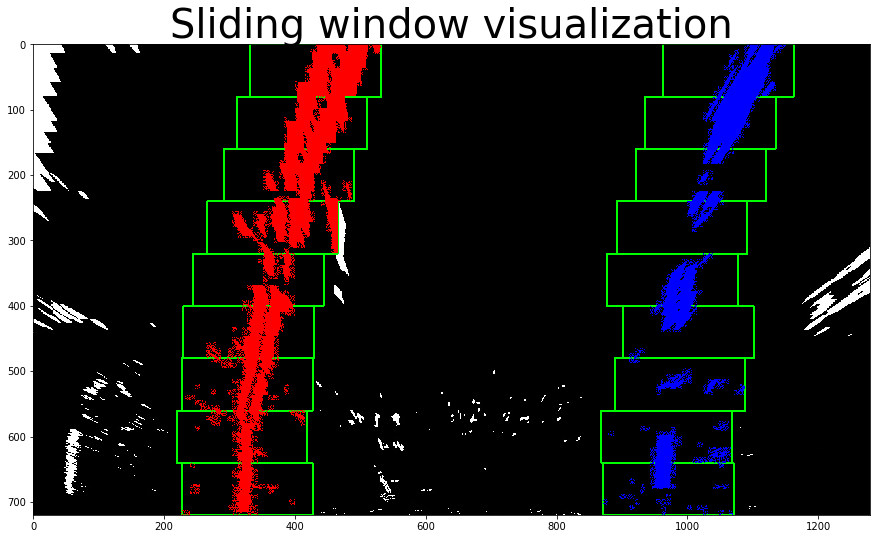

In [7]:
left_posX, left_posY, right_posX, right_posY, out_img = sliding_windows(img, 9, 100, 50, visualize=True)
out_img[left_posY, left_posX] = [255, 0 , 0] # Setting all pixels in left windows as red
out_img[right_posY, right_posX] = [0, 0 , 255] # Setting all pixels in left windows as blue
plt.figure(figsize=(15,15))
plt.imshow(out_img);
plt.title('Sliding window visualization', fontsize=40);

# Fitting a polynomial to the pixel lines (red & blue)

* We would like to fit a polynomial to create a path where we can search in subsequent frames. Hence, this path will help us to avoid running the sliding window algorithm each time a new frame comes.

In [8]:
def fit_polynomial(binary_warped, visualize=False):
    if visualize:
        left_posX, left_posY, right_posX, right_posY, out_img = sliding_windows(img, 9, 100, 50, visualize=visualize)
        out_img[left_posY, left_posX] = [255, 0 , 0] # Setting all pixels in left windows as red
        out_img[right_posY, right_posX] = [0, 0 , 255] # Setting all pixels in left windows as blue
    else:
        left_posX, left_posY, right_posX, right_posY = sliding_windows(img, 9, 100, 50)
    
    # Fit a 2nd order polynomial
    left_fit_coeff = np.polyfit(left_posY, left_posX, 2)
    right_fit_coeff = np.polyfit(right_posY, right_posX, 2)
    
    y = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitX = left_fit_coeff[0]*y**2+left_fit_coeff[1]*y+left_fit_coeff[2]
    right_fitX = right_fit_coeff[0]*y**2+right_fit_coeff[1]*y+right_fit_coeff[2]
    
    if visualize:
        # plotting fitted polynomial to the image.
        plt.figure(figsize=(700/1200*25,1200/700*25))
        plt.title('Sliding window + fitted polynomial visualization', fontsize=40)
        plt.plot(left_fitX, y, color='yellow')
        plt.plot(right_fitX, y, color='yellow')
        plt.imshow(out_img)
        
    return left_fitX, right_fitX

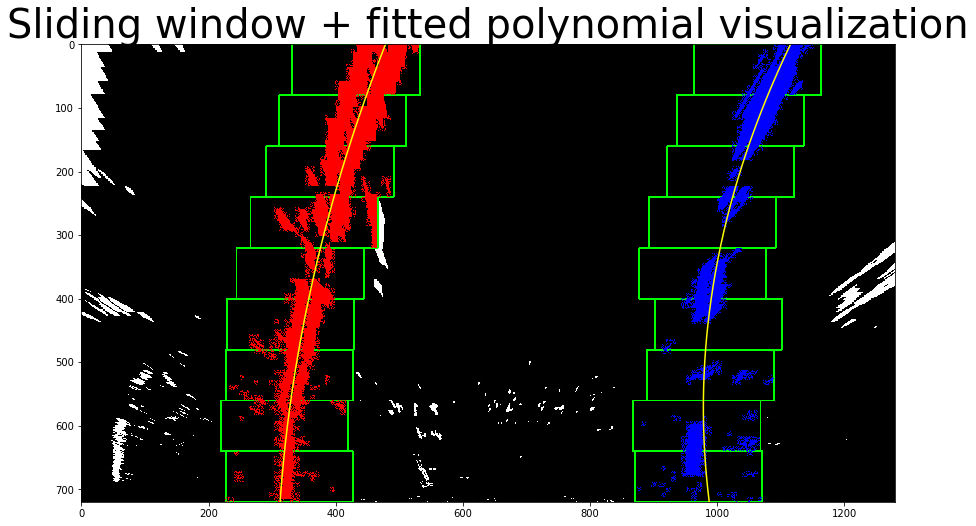

In [9]:
fit_polynomial(img, visualize=True);